In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy.ma as ma

In [2]:
baseDir = "./save/server2Models/sketch-rnn/model1/"
meansVT = torch.load(baseDir+"validation_means", map_location="cpu")
stdsVT = torch.load(baseDir+"validation_stds", map_location="cpu")
targetsVT = torch.load(baseDir+"targetsV", map_location="cpu")
inputsVT = torch.load(baseDir+"datasV", map_location="cpu")
meansTT = torch.load(baseDir+"train_means", map_location="cpu")
stdsTT = torch.load(baseDir+"train_stds", map_location="cpu")
targetsTT = torch.load(baseDir+"targetsT", map_location="cpu")
inputsTT = torch.load(baseDir+"datasT", map_location="cpu")
trainDataMean = torch.load(baseDir+"train_mean", map_location="cpu")
trainDataStd = torch.load(baseDir+"train_std", map_location="cpu")
valDataMean = torch.load(baseDir+"val_mean", map_location="cpu")
valDataStd = torch.load(baseDir+"val_std", map_location="cpu")
avgTrainKLDLosses = torch.load(baseDir+"mean_train_kld_losses_per_timestep", map_location="cpu")
avgValKLDLosses = torch.load(baseDir+"mean_validation_kld_losses_per_timestep", map_location="cpu")
plotTrainKLDLosses = torch.load(baseDir+"plot_train_kld_losses", map_location="cpu")
plotValKLDLosses = torch.load(baseDir+"plot_val_kld_losses", map_location="cpu")
plotTrainReconLosses = torch.load(baseDir+"plot_train_recon_losses", map_location="cpu")
plotValReconLosses = torch.load(baseDir+"plot_val_recon_losses", map_location="cpu")
learningRates = torch.load(baseDir+"learningRates", map_location="cpu")
dataTimesArrTrain = np.array(torch.load(baseDir+"dataTimesArrTrain", map_location="cpu"))
dataTimesArrTrain = np.reshape(dataTimesArrTrain, (-1, dataTimesArrTrain.shape[-1]))
targetTimesArrTrain = np.array(torch.load(baseDir+"targetTimesArrTrain", map_location="cpu"))
targetTimesArrTrain = np.reshape(targetTimesArrTrain, (-1, targetTimesArrTrain.shape[-1]))
dataTimesArrVal = np.array(torch.load(baseDir+"dataTimesArrVal", map_location="cpu"))
dataTimesArrVal = np.reshape(dataTimesArrVal, (-1, dataTimesArrVal.shape[-1]))
targetTimesArrVal = np.array(torch.load(baseDir+"targetTimesArrVal", map_location="cpu"))
targetTimesArrVal = np.reshape(targetTimesArrVal, (-1, targetTimesArrVal.shape[-1]))
trainZ = torch.load(baseDir+"train_Zs", map_location="cpu")
valZ = torch.load(baseDir+"validation_Zs", map_location="cpu")

In [3]:
meansMatT = [np.concatenate([y.cpu().data.numpy() for y in meansTT[i]], axis=0) for i in range(len(meansTT))]

In [4]:
stdsMatT = [np.concatenate([y.cpu().data.numpy() for y in stdsTT[i]], axis=0) for i in range(len(stdsTT))]

In [5]:
meansMatV = [np.concatenate([y.cpu().data.numpy() for y in meansVT[i]], axis=0) for i in range(len(meansVT))]

In [6]:
stdsMatV = [np.concatenate([y.cpu().data.numpy() for y in stdsVT[i]], axis=0) for i in range(len(stdsVT))]

In [8]:
trainTimeOrder = dataTimesArrTrain[:,0].argsort()
valTimeOrder = dataTimesArrVal[:,0].argsort()
dataTimesArrTrain = dataTimesArrTrain[trainTimeOrder]
targetTimesArrTrain = targetTimesArrTrain[trainTimeOrder]
dataTimesArrVal = dataTimesArrVal[valTimeOrder]
targetTimesArrVal = targetTimesArrVal[valTimeOrder]
meansT = np.concatenate([p for p in meansMatT], axis=1)[:,trainTimeOrder,:]
stdsT = np.concatenate([p for p in stdsMatT], axis=1)[:,trainTimeOrder,:]
targetsT = np.concatenate([t for t in targetsTT], axis=1)[:,trainTimeOrder,:]
datasT = np.concatenate([d for d in inputsTT], axis=1)[:,trainTimeOrder,:]
meansV = np.concatenate([p for p in meansMatV], axis=1)[:,valTimeOrder,:]
stdsV = np.concatenate([p for p in stdsMatV], axis=1)[:,valTimeOrder,:]
targetsV = np.concatenate([t for t in targetsVT], axis=1)[:,valTimeOrder,:]
datasV = np.concatenate([d for d in inputsVT], axis=1)[:,valTimeOrder,:]

In [9]:
def getScaledSamples(generatorMean, generatorStd, dataMean, dataStd):
    standardizedSamples = np.random.normal(generatorMean, generatorStd, size=(100, generatorMean.shape[0]))
    samples = (standardizedSamples * dataStd) + dataMean
    meanofsamples = np.mean(samples, axis=0)
    stdofsamples = np.std(samples, axis=0)
    return samples, meanofsamples, stdofsamples

In [10]:
def inMinutes(td):
    return (td.seconds//60)%60

In [11]:
def plotNHours(means, stds, targets, datas, dataset, dataMean, dataStd, targetTimes, N=24):
    instance = np.random.randint(targets.shape[1])
    sensor = np.random.randint(targets.shape[2])
    sequenceTrueMean = []
    sequenceTrueStd = []
    sequenceSampleMean = []
    sequenceSampleStd = []
    sequenceTarget = []
    sequenceTimes = []
    shouldMask = []
    maskindex = []
    lastTime = None
    for tStep in range(N):
        realIndex = instance + 12 * tStep
        if realIndex >= means.shape[1]:
            break
        if lastTime and inMinutes(targetTimes[realIndex, -1] - lastTime) > 5:
            shouldMask += [True]
        else:
            shouldMask += [False]
        lastTime = targetTimes[realIndex, -1]
        maskindex += [len(sequenceTrueMean)]
        m = means[:, realIndex, sensor]
        std = stds[:, realIndex, sensor]
        predSamples, sampleMean, sampleStd = getScaledSamples(m, std, dataMean, dataStd)
        sequenceTrueMean += list(m)
        sequenceTrueStd += list(std)
        sequenceSampleMean += list(sampleMean)
        sequenceSampleStd += list(sampleStd)
        sequenceTarget += list(targets[:, realIndex, sensor])
        sequenceTimes += list(targetTimes[realIndex])
        
    #f, ax = plt.subplots(2, sharex=True)
    #f.subplots_adjust(hspace=.5)
    """
    maskedSampleMean = ma.array(sequenceSampleMean)
    maskedTarget = ma.array(sequenceTarget)
    print(maskindex)
    print(shouldMask)
    print(maskedSampleMean.shape)
    for idx, should in zip(maskindex, shouldMask):
        if should:
            maskedSampleMean[idx] = ma.masked
            maskedTarget[idx] = ma.masked
    """
    #print(np.max(sequenceSampleStd), sequenceTimes[np.argmax(sequenceSampleStd)])
    #print(sequenceSampleMean)
    f, ax = plt.subplots()
    f.set_figwidth(15)
    plt.plot(sequenceTimes, sequenceSampleMean, label="pred")
    plt.plot(sequenceTimes, sequenceTarget, label="target")
    plt.fill_between(sequenceTimes,np.array(sequenceSampleMean)-1.96*np.array(sequenceSampleStd), np.array(sequenceSampleMean)+1.96*np.array(sequenceSampleStd), alpha=0.5)
    plt.xticks(rotation=90)
    xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
    ax=plt.gca()
    ax.xaxis.set_major_formatter(xfmt)
    plt.legend()
    plt.ylabel("mile/h")
    plt.title("{} Hour Sample Prediction {}".format(N, dataset))
    yMin = np.min((np.min(sequenceSampleMean)-10, np.min(sequenceTarget)-10, 10))
    yMax = np.max((np.max(sequenceSampleMean)+10, np.max(sequenceTarget)+10, 70))
    #plt.ylim((yMin,yMax))

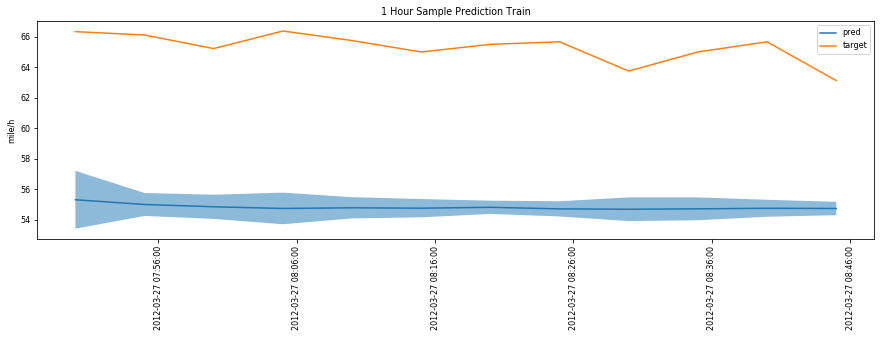

In [58]:
plotNHours(meansT, stdsT, targetsT, datasT, "Train", trainDataMean, trainDataStd, targetTimesArrTrain, N=1)

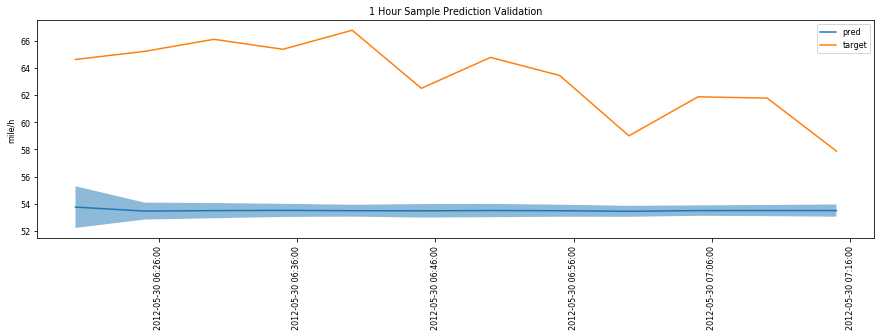

In [60]:
plotNHours(meansV, stdsV, targetsV, datasV, "Validation", valDataMean, valDataStd, targetTimesArrVal, N=1)

In [34]:
def plotRandomInstanceVRNN(means, stds, targets, datas, dataset, dataMean, dataStd):
    instance = np.random.randint(targets.shape[1])
    sensor = np.random.randint(targets.shape[2])
    m = means[:, instance, sensor]
    std = stds[:, instance, sensor]
    print(m)
    print(std)
    t = targets[:, instance, sensor]
    d = datas[:,instance, sensor]
    predSamples, samplesMean, samplesStd = getScaledSamples(m, std, dataMean, dataStd)
    f, ax = plt.subplots(2, sharex=True)
    f.subplots_adjust(hspace=.5)
    ax[0].plot(range(0,60, 5),samplesMean, label="pred")
    ax[0].fill_between(range(0,60, 5),samplesMean-1.96*samplesStd, samplesMean+1.96*samplesStd, alpha=0.5)
    ax[0].plot(range(0,60, 5),t, label="target")
    ax[0].plot(range(-60,0, 5), d, label="input")
    ax[0].legend()
    ax[0].set_xlabel("Minutes relative to prediction time")
    ax[0].set_ylabel("Speed (mph)")
    ax[0].set_title("random sensor sample {}".format(dataset))
    ax[1].plot(range(0,60, 5), m, label="mean")
    ax[1].fill_between(range(0,60, 5),m-1.96*std, m+1.96*std, alpha=0.5)
    ax[1].set_title("True mean and 95% C.I.")

[0.02320674 0.00363589 0.00168532 0.00125368 0.00125604 0.00126987
 0.00109852 0.00094622 0.00084228 0.00089209 0.0011191  0.00099444]
[0.0773169  0.02396539 0.01473665 0.01177096 0.01094771 0.01110876
 0.0108359  0.01007194 0.00941148 0.00887692 0.01004471 0.00995097]


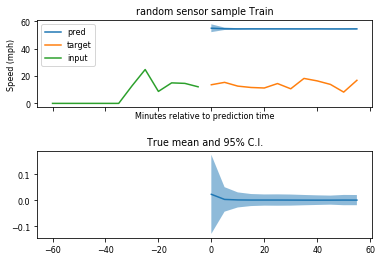

In [61]:
plotRandomInstanceVRNN(meansT,stdsT, targetsT, datasT, "Train", trainDataMean, trainDataStd)

[0.09255144 0.04978677 0.04329012 0.04224544 0.04216135 0.04264957
 0.04026564 0.0371688  0.03837245 0.03964732 0.03911596 0.04036989]
[0.03987537 0.01479214 0.01179167 0.01135519 0.01122084 0.012379
 0.01148062 0.00997442 0.01049301 0.01037789 0.01099219 0.01176471]


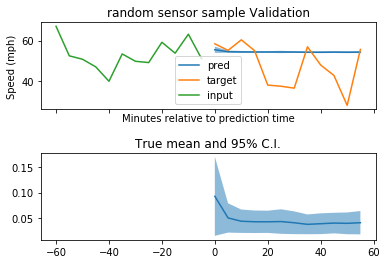

In [44]:
plotRandomInstanceVRNN(meansV, stdsV, targetsV, datasV, "Validation", valDataMean, valDataStd)

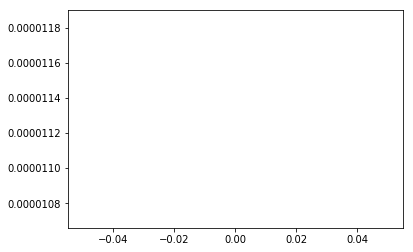

In [45]:
plt.plot(avgTrainKLDLosses)

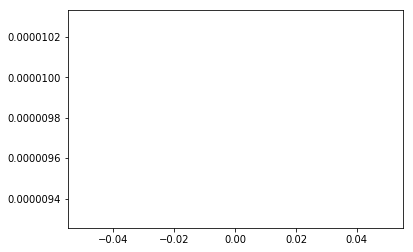

In [46]:
plt.plot(avgValKLDLosses)

In [63]:
def plotTrainValCurve(trainLosses, valLosses, trainKLDLosses=None, valKLDLosses=None, upTo=20):
    plot_every = 1
    plt.rcParams.update({'font.size': 8})
    plt.figure()
    fig, ax1 = plt.subplots()
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("loss", color="r")
    ax1.tick_params('y', colors='r')
    ax1.plot(np.arange(1, len(trainLosses)+1)[:upTo]*plot_every, trainLosses[:upTo], "r--", label="train reconstruction loss")
    ax1.plot(np.arange(1, len(valLosses)+1)[:upTo]*plot_every, valLosses[:upTo], color="red", label="validation reconstruction loss")
    ax1.legend(loc="upper left")
    ax1.grid()
    if trainKLDLosses:
        ax2 = ax1.twinx()
        ax2.set_ylabel("KLD Loss", color="b")
        ax2.tick_params('y', colors='b')
        ax2.plot(np.arange(1, len(trainKLDLosses)+1)[:upTo]*plot_every, trainKLDLosses[:upTo], "b--", label="train KLD loss")
        ax2.plot(np.arange(1, len(valKLDLosses)+1)[:upTo]*plot_every, valKLDLosses[:upTo], color="blue", label="val KLD loss")
        ax2.legend(loc="upper right")
        ax2.grid()
    plt.title("Losses for VRNN")

<Figure size 432x288 with 0 Axes>

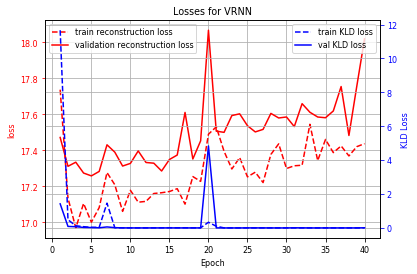

In [72]:
plotTrainValCurve(plotTrainReconLosses, plotValReconLosses, plotTrainKLDLosses, plotValKLDLosses, upTo=40)

In [73]:
def plotTrainValCurveTotal(trainLosses, valLosses, trainKLDLosses=None, valKLDLosses=None, upTo=20):
    plot_every = 1
    plt.rcParams.update({'font.size': 8})
    plt.figure()
    fig, ax1 = plt.subplots()
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("loss", color="r")
    ax1.tick_params('y', colors='r')
    trainLoss = np.array(trainLosses[:upTo]) + np.array(trainKLDLosses[:upTo])
    valLoss = np.array(valLosses[:upTo]) + np.array(valKLDLosses[:upTo])
    ax1.plot(np.arange(1, len(trainLoss)+1)*plot_every, trainLoss, label="train total loss")
    ax1.plot(np.arange(1, len(valLoss)+1)*plot_every, valLoss, label="validation total loss")
    ax1.legend(loc="upper left")
    ax1.grid()
    plt.title("Losses for Sketch-RNN")

<Figure size 432x288 with 0 Axes>

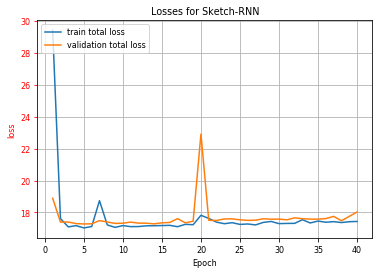

In [74]:
plotTrainValCurveTotal(plotTrainReconLosses, plotValReconLosses, plotTrainKLDLosses, plotValKLDLosses, upTo=40)

Text(0.5,1,'Average loss by timestep, Train')

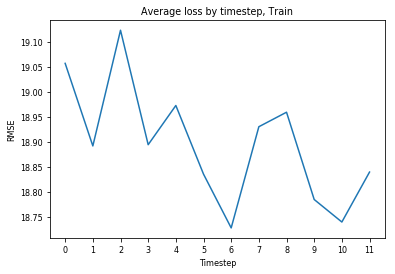

In [55]:
plt.plot(np.sqrt(np.mean(((trainDataMean + trainDataStd* meansT) - targetsT)**2, axis=(1,2))))
ticks = plt.xticks(np.arange(0,12))
plt.ylabel("RMSE")
plt.xlabel("Timestep")
plt.title("Average loss by timestep, Train")

Text(0.5,1,'Average loss by timestep, Val')

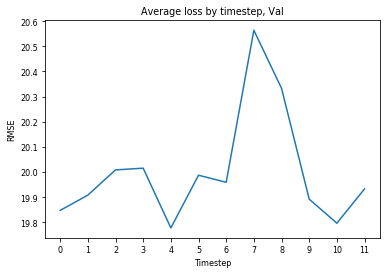

In [56]:
plt.plot(np.sqrt(np.mean(((valDataMean + valDataStd* meansV) - targetsV)**2, axis=(1,2))))
ticks = plt.xticks(np.arange(0,12))
plt.ylabel("RMSE")
plt.xlabel("Timestep")
plt.title("Average loss by timestep, Val")